<a href="https://colab.research.google.com/github/EduS3000/KURF2023/blob/main/KURF2023Focal_or_Rotor_Point.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Notebook for deep learning model predicting either rotor or focal point from synthetic ECG (binary classification)

In [2]:
# Import necessary modules:
import os,glob
import random
import torch
import os.path
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv as csv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from torch.nn.modules.loss import CrossEntropyLoss
from sklearn.metrics import accuracy_score

In [3]:
# Load in data from Google Drive:
# Mount drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = "/content/drive/MyDrive/KURF2023/Method 2 data 04-07 Both spiral locations - 200"
RotorfileNames = []
# Iterate through directory for Rotor points
for path in os.listdir(folder_path):
    # Check if current path is a file
    if os.path.isfile(os.path.join(folder_path, path)):
        RotorfileNames.append(path)
print(RotorfileNames)

In [ ]:
folder_path = "/content/drive/MyDrive/KURF2023/Method 2 data 04-07 Both Focal locations - 200"
FocalfileNames = []
# Iterate through directory for Rotor points
for path in os.listdir(folder_path):
    # Check if current path is a file
    if os.path.isfile(os.path.join(folder_path, path)):
        FocalfileNames.append(path)
print(FocalfileNames)

In [6]:
# Get expected length for each ECG trace:
folder_path = "/content/drive/MyDrive/KURF2023/Method 2 data 04-07 Both Focal locations - 200"
full_path = os.path.join(folder_path, FocalfileNames[1])
ECGfile = open(full_path, 'r');
count = 0
for lineCount in ECGfile:
    if count<1:
        listFloats = lineCount.split("\t")
        x = list(np.float_(listFloats))
        num_traces = len(x)
    count += 1

In [ ]:
# Randomly interweave both filenames arrays:
All_filenames = [x.pop(0) for x in random.sample([FocalfileNames]*len(FocalfileNames) + [RotorfileNames]*len(RotorfileNames), len(FocalfileNames)+len(RotorfileNames))]
print(All_filenames)

In [8]:
# Possible results:
Possible_results = ['Rotor', 'Focal_point']

# Assign value for each coordinate (2 in this case):
Rotor = 0
Focal = 1

In [ ]:
# For all Rotor points:
# For each txt file, read in:
# - Point ECG corresponds to
# - 10 1D ECGs

# Initialise all data sets:
# Location:
ECG_type_RPFP = []
# Values:
All_ECG_Sets = []
Spiral_or_FocalPoint = []

print('Loading')

for f in range(len(All_filenames)):
    rel_path = All_filenames[f]
    # Get type (FP or SP) from title of .txt file:
    class_pointStart = rel_path.find('ce_') + 3
    class_pointEnd = class_pointStart+2
    Point_type = str(rel_path[class_pointStart:class_pointEnd])

    # Check which coordinate to assign to:
    if (Point_type == 'SP'):
      ECG_type_RPFP.append([0])
      folder_path = "/content/drive/MyDrive/KURF2023/Method 2 data 04-07 Both spiral locations - 200"
    elif (Point_type == 'FP'):
      ECG_type_RPFP.append([1])
      folder_path = "/content/drive/MyDrive/KURF2023/Method 2 data 04-07 Both Focal locations - 200"

    print('__________')
    abs_file_path = os.path.join(folder_path, rel_path)
    print(abs_file_path)
    Pwaves_Lii = np.zeros(count)
    Pwaves_Liii = np.zeros(count)
    Pwaves_WCT = np.zeros(count)
    Pwaves_V1 = np.zeros(count)
    Pwaves_V2 = np.zeros(count)
    Pwaves_V3 = np.zeros(count)
    Pwaves_V4 = np.zeros(count)
    Pwaves_V5 = np.zeros(count)
    Pwaves_V6 = np.zeros(count)
    Pwaves_aVF = np.zeros(count)

    ECGfile = open(abs_file_path, 'r');
    # Using for loop to read in the data:
    iteration = 0
    for lineRead in ECGfile:
        listFloats = lineRead.split("\t")
        x = list(np.float_(listFloats))
        Pwaves_Lii[iteration] = x[0]
        Pwaves_Liii[iteration] = x[1]
        Pwaves_WCT[iteration] = x[2]
        Pwaves_V1[iteration] = x[3]
        Pwaves_V2[iteration] = x[4]
        Pwaves_V3[iteration] = x[5]
        Pwaves_V4[iteration] = x[6]
        Pwaves_V5[iteration] = x[7]
        Pwaves_V6[iteration] = x[8]
        Pwaves_aVF[iteration] = x[9]
        iteration += 1
    ECG_Set = [Pwaves_Lii, Pwaves_Liii, Pwaves_WCT, Pwaves_V1, Pwaves_V2, Pwaves_V3, Pwaves_V4, Pwaves_V5, Pwaves_V6, Pwaves_aVF]
    All_ECG_Sets.append(ECG_Set)
    # Close file:
    ECGfile.close()
print('Finished')

In [10]:
# Make All_ECG_Sets and classification array a numpy array:
# Important arrays (data and true values):
All_ECG_Sets = np.array(All_ECG_Sets)
ECG_type_RPFP = np.array(ECG_type_RPFP)
print(All_ECG_Sets.shape)
print(ECG_type_RPFP.shape)

(400, 10, 3500)
(400, 1)


In [11]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, labels_array, images_array, transform=None, target_transform=None):
        self.img_labels = labels_array
        self.all_images = images_array
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = torch.from_numpy(np.float32(self.all_images[idx]))
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


In [12]:
# Make Neural Network using PyTorch:
# Dependencies:
import torch
import PIL
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

In [13]:
# Convert dataset to tensor:
All_data = CustomDataset(labels_array = ECG_type_RPFP, images_array = All_ECG_Sets)
train_data, test_data = random_split(All_data, [350, 50])
dataset = DataLoader(train_data, batch_size=10, shuffle = True)
print(type(All_data))
print(train_data[10])
print(type(dataset))
# 1, 10, 3500 - classes 0-1 so 2

<class '__main__.CustomDataset'>
(tensor([[ 0.0000, -3.1351, -3.1323,  ...,  3.3850,  3.3475,  3.3064],
        [ 0.0000, -2.5245, -2.5214,  ...,  2.7641,  2.7344,  2.7020],
        [ 0.0000, -3.3951, -3.3960,  ...,  3.6056,  3.5755,  3.5418],
        ...,
        [ 0.0000, -0.1528, -0.1555,  ...,  0.1651,  0.1761,  0.1877],
        [ 0.0000, -0.1528, -0.1555,  ...,  0.1651,  0.1761,  0.1877],
        [ 0.0000, -2.8298, -2.8268,  ...,  3.0746,  3.0410,  3.0042]]), array([1]))
<class 'torch.utils.data.dataloader.DataLoader'>


In [14]:
# Create class for image classifier:
# fully connected layer
# hyperparameter tuning
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(10, 50, 10),
            nn.ReLU(),
            nn.Conv1d(50, 50, 10),
            nn.ReLU(),
            nn.Conv1d(50, 50, 10),
            nn.ReLU(),
            nn.Flatten(),
            #nn.Linear(20*(10-6)*(3500-6), 2)
            nn.Linear(173650, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
      x = self.model(x)
      return x

In [17]:
# Function for training:
def TRAIN_MODEL(dataset, fold_i):
  # Create instance of the NN, loss and optimizer:
  clf = ImageClassifier()
  opt = Adam(clf.parameters(), lr=0.00001)
  clf.train()
  loss_fn = torch.nn.BCELoss()

  if __name__ == "__main__":
    loss_set = []
    for epoch in range(10):
      epoch_loss_set = []
      for batch in dataset:
        X,y = batch
        yhat = clf(X)
        y = y.type(torch.float)
        loss_batch = loss_fn(yhat,y)

        # Apply backprop:
        opt.zero_grad()
        loss_batch.backward()
        opt.step()
        epoch_loss_set.append(loss_batch.detach().cpu().numpy())

      # Save loss to loss set for plotting:
      loss_epoch = np.mean(epoch_loss_set)
      loss_set.append(loss_epoch)
      print(f"Epoch:{epoch} loss is {loss_epoch}")

  model_name = 'Model_state' + str(fold_i) + '.pt'

  with open(model_name, 'wb') as f:
    save(clf.state_dict(), f)

  # Loss plot:
  x = np.array(list(range(0,len(loss_set))))
  plt.title("Line graph")
  plt.plot(x, loss_set, color="red")

  plt.show()

  return model_name

Fold:  0
Training epochs...
Epoch:0 loss is 0.5700943470001221
Epoch:1 loss is 0.3162819743156433
Epoch:2 loss is 0.12514586746692657
Epoch:3 loss is 0.04769783839583397
Epoch:4 loss is 0.022553715854883194
Epoch:5 loss is 0.012847492471337318
Epoch:6 loss is 0.008118858560919762
Epoch:7 loss is 0.005647973623126745
Epoch:8 loss is 0.004160633310675621
Epoch:9 loss is 0.0031318897381424904


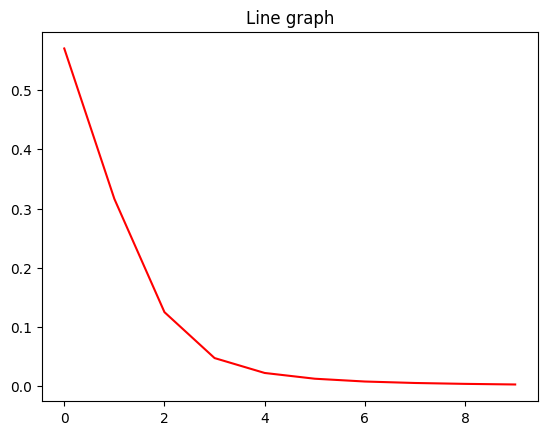

Correct: /n predicted:  0.9949527978897095 /n GT:  1
Correct: /n predicted:  0.0035796884912997484 /n GT:  0
Correct: /n predicted:  0.9897539615631104 /n GT:  1
Correct: /n predicted:  0.9995304346084595 /n GT:  1
Correct: /n predicted:  0.9924492835998535 /n GT:  1
Correct: /n predicted:  0.002295124577358365 /n GT:  0
Correct: /n predicted:  0.0011173572856932878 /n GT:  0
Correct: /n predicted:  0.999578058719635 /n GT:  1
Correct: /n predicted:  0.004715438932180405 /n GT:  0
Correct: /n predicted:  0.9995680451393127 /n GT:  1
Correct: /n predicted:  0.0038971174508333206 /n GT:  0
Correct: /n predicted:  0.999521017074585 /n GT:  1
Correct: /n predicted:  0.9931939840316772 /n GT:  1
Correct: /n predicted:  0.999481737613678 /n GT:  1
Correct: /n predicted:  0.00420009158551693 /n GT:  0
Correct: /n predicted:  0.001992044970393181 /n GT:  0
Correct: /n predicted:  0.9980040192604065 /n GT:  1
Correct: /n predicted:  0.9973438382148743 /n GT:  1
Correct: /n predicted:  0.0009686

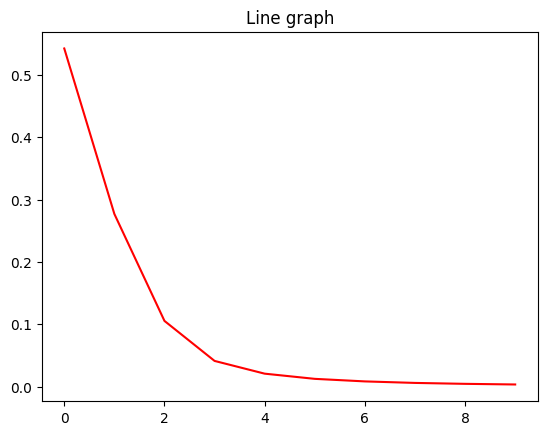

Correct: /n predicted:  0.0025013647973537445 /n GT:  0
Correct: /n predicted:  0.01661687158048153 /n GT:  0
Correct: /n predicted:  0.0005367376725189388 /n GT:  0
Correct: /n predicted:  0.9990168809890747 /n GT:  1
Correct: /n predicted:  0.998257577419281 /n GT:  1
Correct: /n predicted:  0.002200297312811017 /n GT:  0
Correct: /n predicted:  0.9984739422798157 /n GT:  1
Correct: /n predicted:  0.0005526256281882524 /n GT:  0
Correct: /n predicted:  0.001678585191257298 /n GT:  0
Correct: /n predicted:  0.0007593116024509072 /n GT:  0
Correct: /n predicted:  0.9950954914093018 /n GT:  1
Correct: /n predicted:  0.002298629144206643 /n GT:  0
Correct: /n predicted:  0.0017179674468934536 /n GT:  0
Correct: /n predicted:  0.013511400669813156 /n GT:  0
Correct: /n predicted:  0.9958829879760742 /n GT:  1
Correct: /n predicted:  0.002241020556539297 /n GT:  0
Correct: /n predicted:  0.9977104663848877 /n GT:  1
Correct: /n predicted:  0.9994719624519348 /n GT:  1
Correct: /n predicted

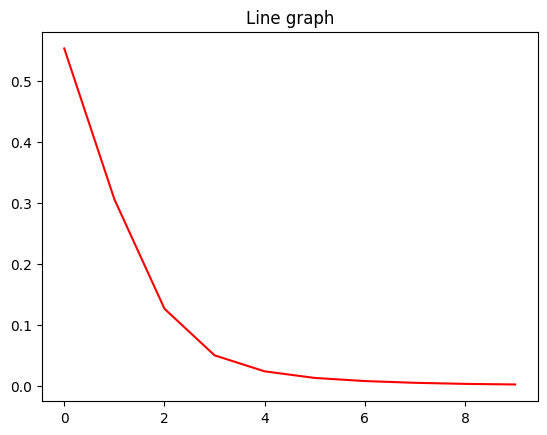

Correct: /n predicted:  0.00023941416293382645 /n GT:  0
Correct: /n predicted:  0.9991644620895386 /n GT:  1
Correct: /n predicted:  0.9996274709701538 /n GT:  1
Correct: /n predicted:  0.0014284797944128513 /n GT:  0
Correct: /n predicted:  0.0002459064999129623 /n GT:  0
Correct: /n predicted:  0.9997245669364929 /n GT:  1
Correct: /n predicted:  0.0011194912949576974 /n GT:  0
Correct: /n predicted:  0.9994328618049622 /n GT:  1
Correct: /n predicted:  0.0015726134879514575 /n GT:  0
Correct: /n predicted:  0.000365735701052472 /n GT:  0
Correct: /n predicted:  0.9993807077407837 /n GT:  1
Correct: /n predicted:  0.0028128039557486773 /n GT:  0
Correct: /n predicted:  0.9996292591094971 /n GT:  1
Correct: /n predicted:  0.032292235642671585 /n GT:  0
Correct: /n predicted:  0.9992815852165222 /n GT:  1
Correct: /n predicted:  0.9991803765296936 /n GT:  1
Correct: /n predicted:  0.0018438936676830053 /n GT:  0
Correct: /n predicted:  0.0003079960879404098 /n GT:  0
Correct: /n predi

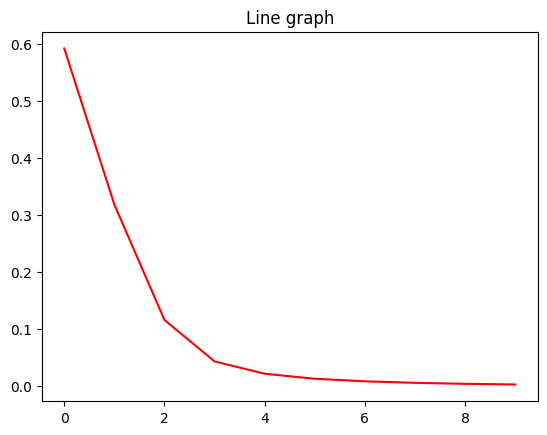

Correct: /n predicted:  0.9990870952606201 /n GT:  1
Correct: /n predicted:  0.999354898929596 /n GT:  1
Correct: /n predicted:  0.9997851252555847 /n GT:  1
Correct: /n predicted:  0.9980064034461975 /n GT:  1
Correct: /n predicted:  0.9993343949317932 /n GT:  1
Correct: /n predicted:  0.9951569437980652 /n GT:  1
Correct: /n predicted:  0.9967299699783325 /n GT:  1
Correct: /n predicted:  0.999347984790802 /n GT:  1
Correct: /n predicted:  0.0017397318733856082 /n GT:  0
Correct: /n predicted:  0.9996281862258911 /n GT:  1
Correct: /n predicted:  0.00031447032233700156 /n GT:  0
Correct: /n predicted:  0.9993357062339783 /n GT:  1
Correct: /n predicted:  0.9981169700622559 /n GT:  1
Correct: /n predicted:  0.9988619089126587 /n GT:  1
Correct: /n predicted:  0.998439610004425 /n GT:  1
Correct: /n predicted:  0.0005340732168406248 /n GT:  0
Correct: /n predicted:  0.0029078421648591757 /n GT:  0
Correct: /n predicted:  0.0003404577437322587 /n GT:  0
Correct: /n predicted:  0.9976974

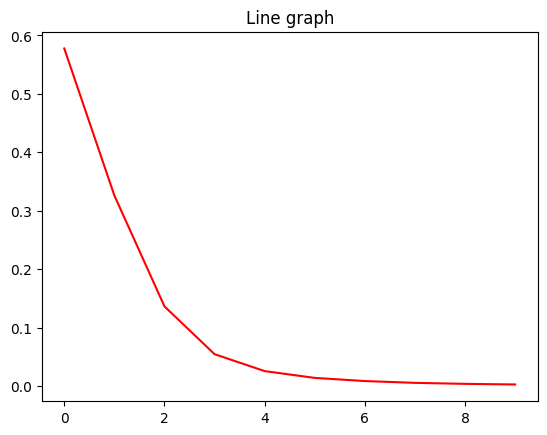

Correct: /n predicted:  0.9983614087104797 /n GT:  1
Correct: /n predicted:  0.002649432048201561 /n GT:  0
Correct: /n predicted:  0.0023596875835210085 /n GT:  0
Correct: /n predicted:  0.0008671869290992618 /n GT:  0
Correct: /n predicted:  0.0014136347454041243 /n GT:  0
Correct: /n predicted:  0.001175871235318482 /n GT:  0
Correct: /n predicted:  0.9956331849098206 /n GT:  1
Correct: /n predicted:  0.9986042380332947 /n GT:  1
Correct: /n predicted:  0.9971567392349243 /n GT:  1
Correct: /n predicted:  0.9989853501319885 /n GT:  1
Correct: /n predicted:  0.9978501796722412 /n GT:  1
Correct: /n predicted:  0.9989567995071411 /n GT:  1
Correct: /n predicted:  0.9989043474197388 /n GT:  1
Correct: /n predicted:  0.9989534616470337 /n GT:  1
Correct: /n predicted:  0.9990999698638916 /n GT:  1
Correct: /n predicted:  0.007975810207426548 /n GT:  0
Correct: /n predicted:  0.0015624952502548695 /n GT:  0
Correct: /n predicted:  0.0030307539273053408 /n GT:  0
Correct: /n predicted:  0

In [18]:
# KFold training:
# KFold split:
k=5
kf = KFold(n_splits=k, random_state=None, shuffle=False)

# KFold split:
#for i, (train_index, test_index) in enumerate(kf.split(All_data)):
#  print(f"Fold {i}:")
#  print(f"  Train: index={len(train_index)}")
#  print(f"  Test:  index={len(test_index)}")

acc_score = []

for fold_indx, (train_index, test_index) in enumerate(kf.split(All_data)):
  #print(f"Fold {fold_indx}:")
  #print(f"  Train: index={train_index}")
  #print(f"  Test:  index={test_index}")

  print('Fold: ', fold_indx)
  print('Training epochs...')
  # Training dataset:
  train_data = []
  for i in range(len(train_index)):
    train_data.append(All_data[train_index[i]])
  # Testing dataset:
  test_data = []
  for j in range(len(test_index)):
    test_data.append(All_data[test_index[j]])

  dataset = DataLoader(train_data, batch_size=10, shuffle = True)

  # Train model:
  fold_model_name = TRAIN_MODEL(dataset, fold_indx)

  # Check accuracy of model of fold:
  clf = ImageClassifier()
  with open(fold_model_name, 'rb') as f:
    clf.load_state_dict(load(f))

  clf.eval()

  correct = 0
  wrong = 0

  with torch.no_grad():
    for index in range(len(test_data)):
      ECG_test_tensor = test_data[index][0].unsqueeze(0)
      predval = clf(ECG_test_tensor).item()
      if (predval>0.5):
        pred = 1
      else:
        pred = 0

      #print('Prediction = ', predval, ' which equates to ', pred)
      #print('GT = ', test_data[index][1][0])
      if (pred==test_data[index][1][0]):
        print('Correct: /n', 'predicted: ', predval, '/n GT: ', test_data[index][1][0])
        correct = correct+1
      else:
        #print('Wrong, ', pred, ' != ', test_data[index][1][0])
        wrong = wrong+1
    print('Accuracy for fold ', fold_indx, ' = ', correct/len(test_data))
    print('_____________________________________')
    acc_score.append(correct/len(test_data))

avg_acc_score = 10

#print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy = ', sum(acc_score)/len(acc_score))